# Colab データインストール

In [0]:
# 以下を実行すると、認証情報を取得するための許可を求められるので、許可してトークンを発行し、テキストボックスに貼り付ける。
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [0]:
# Colabにおいてデータを読みこむ。グーグルドライブをマウントします。その為に必要なパッケージを取得しておく。
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


In [0]:
# 以下実行により、今度は google-drive-ocamlfuse によるアクセスの許可を聞かれる。これも許可する。
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [5]:
# 今回は指定したフォルダのみマウントする
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1FwGdPnKlcYYRe1mZGE5Ci-PWlIY8k5J7/" config
# 上記が正常に終われば、ようやくマウントが可能となる。
!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

Clearing cache...done
8_10-11  compare-deeplibs.ipynb		       test.ipynb
8_12-13  dataマウントテンプレ.ipynb	       week3-EDA
8_3-4	 dataset			       week4
8_5-6	 Kaggle_0
8_7-8	 Santander_Value_Prediction_Challenge


In [1]:
# これ以降はターミナルと同様にディレクトリを扱える
ls

config  datalab/  drive/


In [2]:
cd drive/dataset/Titanic/

/content/drive/dataset/Titanic


In [3]:
ls

gender_submission.csv  test.csv  train.csv  train.html  train_profile.html


# 本編

## Import

## 問題提起

今回の目的は、タイタニックの生存予測を行うことです。

## データ取得

In [0]:
# pandas and numpy for data manipulation
import numpy as np
import pandas as pd 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
# from sklearn.preprocessing import LabelEncoder

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn
# from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
# from sklearn.metrics import  mean_squared_error

In [0]:
# pandasのデータの表示設定
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_row', 15)

In [60]:
# データフレームの読み込み
train = pd.read_csv('train.csv')
train.head(25)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
...,...,...,...,...,...,...,...,...,...,...,...,...
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C


In [0]:
# IDはデータとして不要なためDropする
train_id = train['PassengerId']
train = train.drop(['PassengerId'], axis=1)

## データ探索(EDA)

まず今回はデータ容量が少ないこともあるためデータの概要を掴むのには  
pandas-profilingを利用します。  
これでnote内で検索機能を使えば該当のカラムを細かく見ることも可能になります  
htmlファイルを別タブで開くのがベスト！  

EDAとして特にチョックする項目は4点です  
・欠損値  
・カテゴリー変数  
・外れ値  
・Target変数と説明変数の相関  

ただし今回はランダムフォレストを用いるためカテゴリー変数は処理する  
訳ではなく、確認するだけです。

In [8]:
!pip install pandas-profiling

In [0]:
import pandas_profiling as pdp

profile = pdp.ProfileReport(train)
profile.to_file(outputfile="train.html")

from IPython.display import HTML
HTML(filename='train.html')

読み取れたこと 

・**欠損値 ** 
Age has 177 / 19.9% missing values Missing  
Cabin has 687 / 77.1% missing values Missing  
EmbarkedもMissing (n)	2ある  
欠損値有無にprofilingは向かないと思った(リスト化されていないため)  
missingoやisnull()ベター

・**カテゴリー変数**  
4つある  
train.info()の方がベター

・**外れ値**  
Fare(乗船料金)に、512と他と倍高い数値が3つある(異常値ではなさそう)  
Fare　Zeroも15いる。許容。  
外れ値はprofiling使うと確認しやすいと思った。

・**Target変数と説明変数の相関**  
Pclassが負の相関、Fareが正の相関が強い  

これらを踏まえ、グラフ化する前に、前処理をして行きます！

## 前処理

機械学習は主に「欠損値」「カテゴリー変数」「外れ値」の処理ですが  
今回は欠損値のみの処理が必要です  

・欠損値  
Age has 177 / 19.9% missing values Missing  
Cabin has 687 / 77.1% missing values Missing  
EmbarkedもMissing (n)	2

In [0]:
# 欠損しているところは中央値を当てる
train["Age"].fillna(train.Age.median(), inplace=True)
train["Fare"].fillna(train.Fare.median(), inplace=True)

# 欠損の多いデータをdropする
train = train.drop(['Cabin'],axis=1)

# 最頻値を当てる
train['Embarked'].fillna('S', inplace=True)


In [11]:
# 欠損チェック
train.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

### (こちらはメモです)標準化

今回はカテゴリーが含まれている状態なのでtype指定してあげないと  
処理を行うことができません。  
時短のためにスキップします

前処理が終わったタイミングで標準化を行いましょう。  
「比較する前に標準化」をモットーに生きましょう。

In [0]:
# train = (train - train.mean())/ train.std()

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# train = sc.fit_transform(train)

In [13]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## グラフ化

では、細かくそれぞれのデータの関係を可視化し確認します  

男性と女性では、直感ですが生存率に差がありそうですね。  
男性が女性や子供を優先して生かそうと頑張りそうです。  
早速見てみましょう
(Ageについてもあとで見ています)  

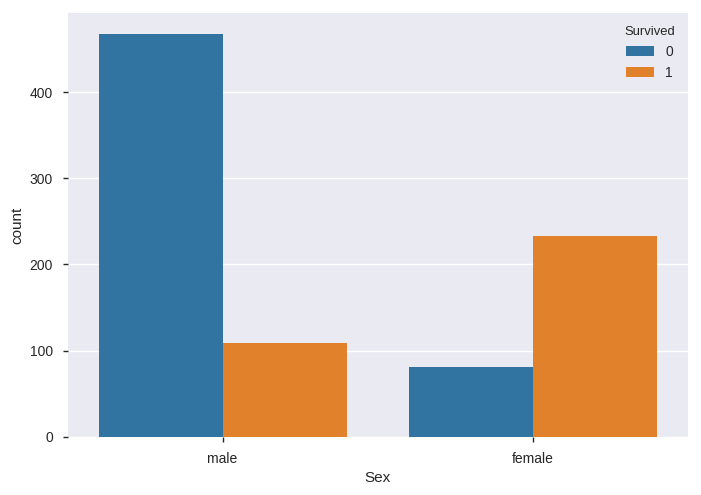

In [14]:
sns.countplot('Sex',hue='Survived',data=train)

明らかに男性＜女性の関係が見られます。   
女性の方が生き残ります！  
これは決定木モデルの中にも採用されることが予想できます。  
___

 ペアプロット図  

今回はもともと数値データのもののみがプロットされています。  

「メモ」2値分類にペアプロットはあまり向かない

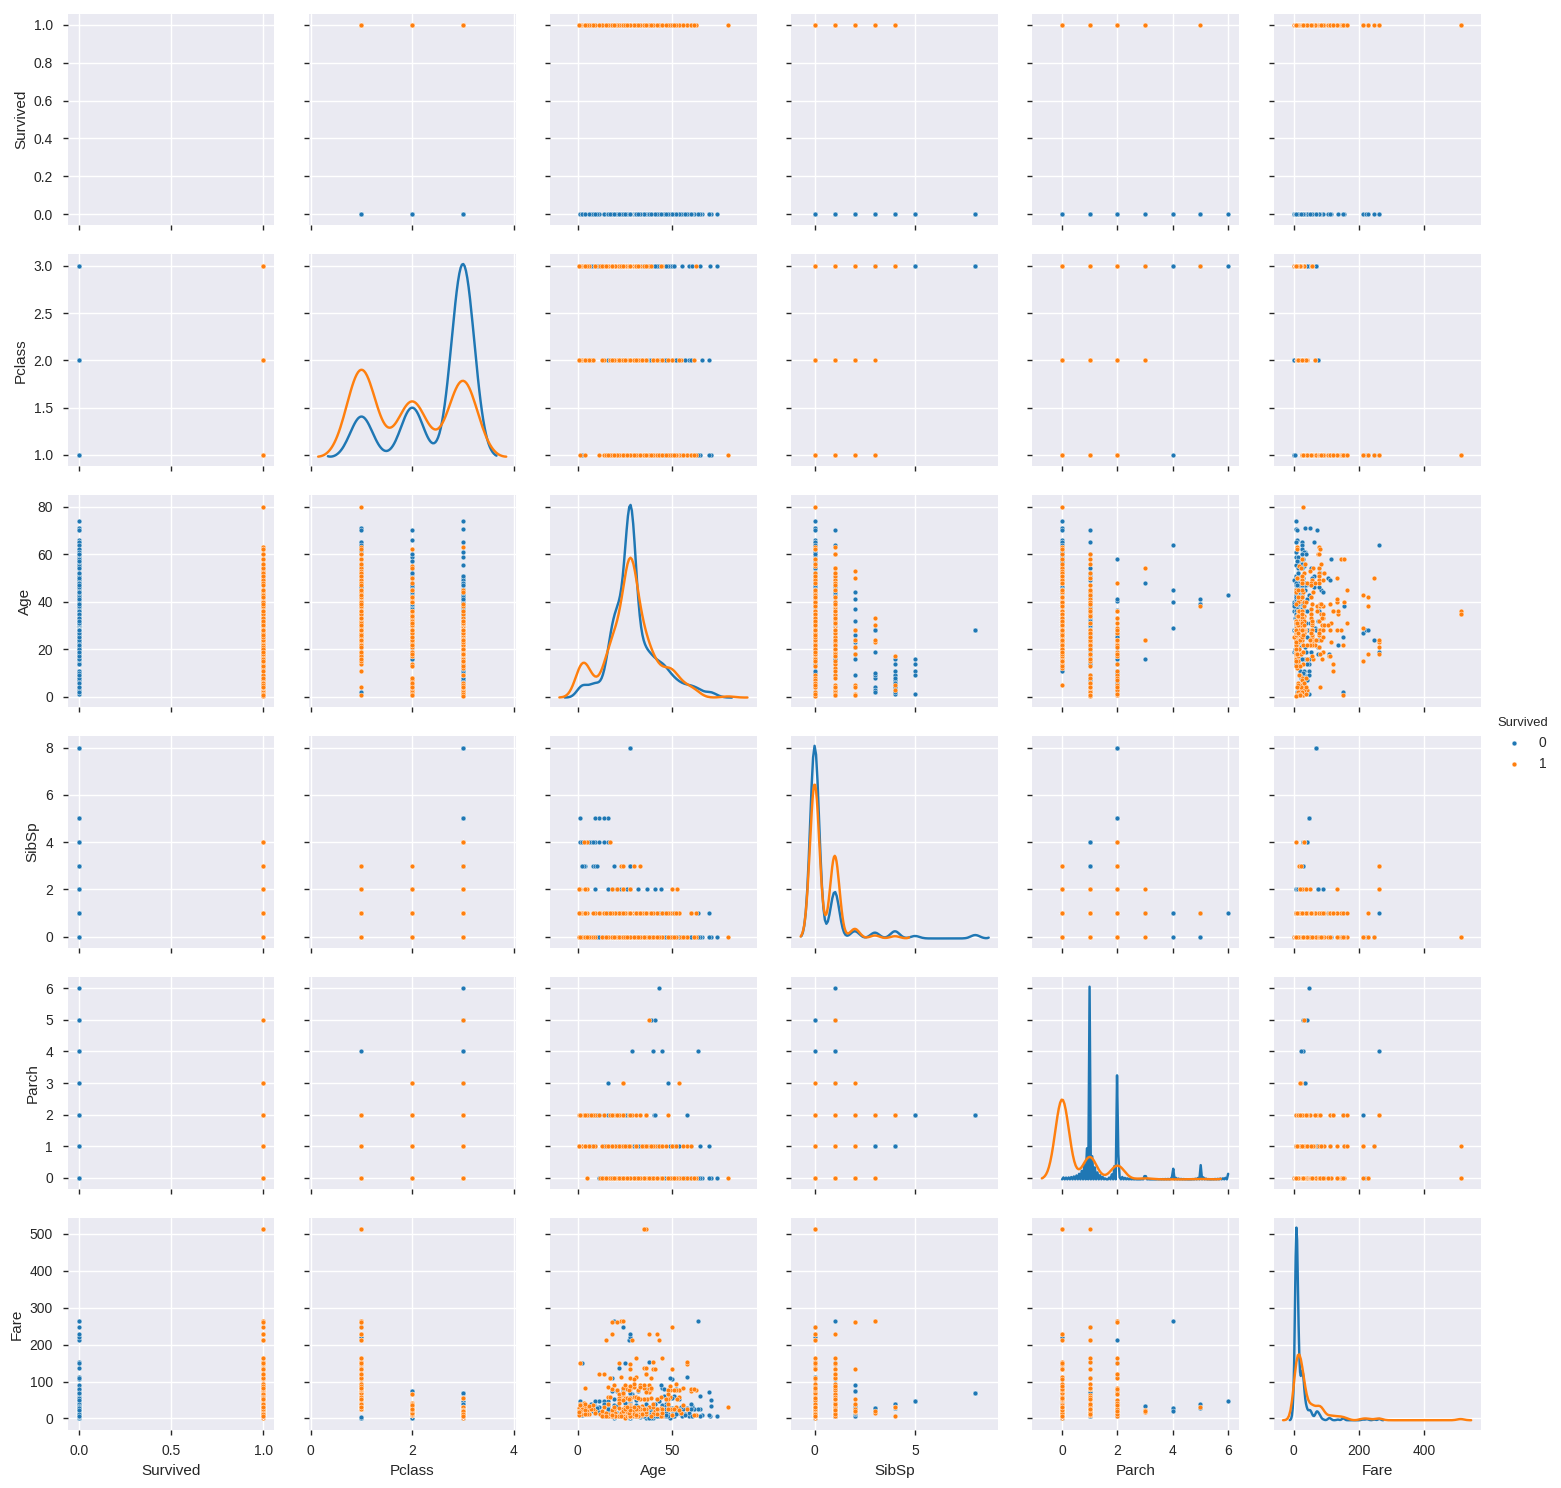

In [15]:
sns.pairplot(train, hue='Survived', diag_kind='kde', size = 2.5,
                      plot_kws={'marker': '.'})

# 引数hueにカテゴリデータが格納された列の列名を指定すると、そのカテゴリごとに色分けしたグラフが生成される。
# kind='reg'とすると散布図に線形回帰の回帰直線が重ねてプロットされる。

このペアプロットはいくつかのことが読み取れます  

まずカーネル密度推定（対角線のグラフ）のPclassを見て見るとわかります
(カーネル密度推定は、一言で表すと「なめらかなヒストグラム」です)  
Pclassは乗客の階級で 1が一番位が高いようですが、  
それによって明らかな0,1の分布に差が現れています。  

他にもAgeの特別若い子は生き残った傾向が見られます  


## 前処理について記述せよ
### この段階でdiverの前処理コードに気づいたため利用させていただきます。  



- 前処理とは何か  
データを扱いやすくしたり、補完したり、誤りをなおすことです

- なぜ前処理を行う必要があるのか  
データには欠損値やカテゴリー変数、外れ値といった数字として扱うことができなかったり  
データとして誤りがのあるものはなおす必要があります。  
数字として扱う主な理由は機械学習のモデルが数値データしか扱えないものも多いためです。  

- 前処理は具体的に何を行うか(3つ以上記述せよ)  
１、欠損値は補完します。平均値や中央値をデータを見て判断して当てます。  
２、カテゴリー変数はラベルエンコーダーやホットエンコーダーを用いたりして数字データに変化します  
３、外れ値は、まずデータを良く確認し、それが異常な値であった場合は現実的な数字（例えば平均値）に置き換えてあげます。    

In [0]:
# 新しくデータをインポートしてそれを前処理をする
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [17]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [18]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


### 前処理の内容について記述せよ


- **simplify_ages**  
Ageをそれぞれの年齢別にカテゴライズしています。  
欠損値については'Unknown'としてカテゴライズしています。  
私の処理では数値化してしまっていたのでこれは大きな違いです  
こちらの処理のまま識別できる方がモデルとしては理想的です。
ただしカテゴライズする方がスコアができるかはわかりません  
理由はマニュアルで閾値を設定するよりグリッドサーチの方が  
目的にとって有効な良い閾値を見つけてくれそうだからです  
連続値のままの方が機械にとって情報量が多かったとも思います。

- **simplify_cabins**  
cabin(部屋番号)の欠損値をNと置き換えています

- **simplify_fares**  
ageと同じく、値段別にカテゴライズをしています。  

- **format_name**  
Mr.か、Mrs.かのように、シンプルなカテゴライズに変えています。  
もともと数値データという訳ではないですし、  
例えばもし偶然Bobが生き残っていた場合を学習してしまい  
汎用性の悪い過学習を避けることができていると考えます。  

- **drop_features**  
'Embarked'をドロップするのは勿体無いのではないかもしれません。  
'Embarked'について下で可視化してその重要性を確認したいと思います

- **encode_features**  
これはシンプルにsklearnのラベルエンコーダを用いて  
カテゴリー変数を数値化している関数です。  
0 or 1ではなく、その特徴の種類の分、数値が用意されています。


___
**'Embarked'の重要性の確認**  
Embarked は乗船した港です。これを  
Cherbourg : 0  
Queenstown: 1  
Southampton: 2  
として変形します。  



In [0]:
le = preprocessing.LabelEncoder()
le.fit(train['Embarked'])
train['Embarked'] = le.transform(train['Embarked'])

le = preprocessing.LabelEncoder()
le.fit(train['Survived'])
train['Survived'] = le.transform(train['Survived'])

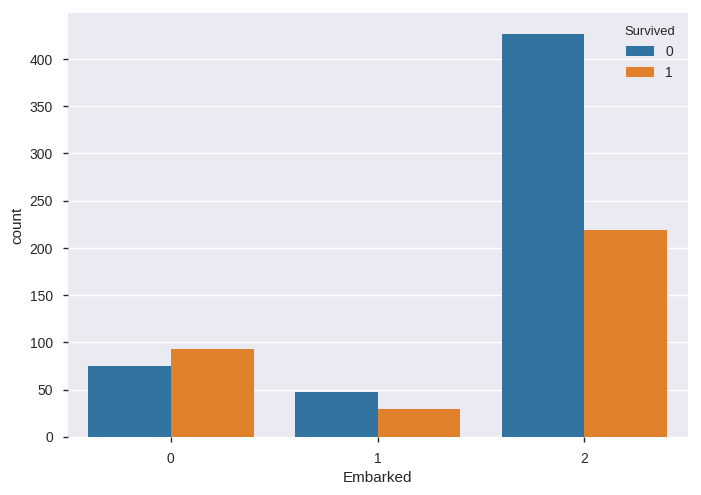

In [20]:
# 'Embarked'の重要性
sns.countplot(x='Embarked', hue='Survived',data=train)

2番(Southampton)が顕著ですが、差があります  
差があるということはそこで「生存or死亡」を判断する材料にできるということです。  
ですので、Dropするのは勿体無いかもしれません。  
とりあえず今の所は、目標の精度が出ない場合にのみ追加することにして  
最終兵器として考えておきます


## モデル選択

モデル選択について記述せよ  
今回使用するモデルは決定していますが、モデル選択をする際の演習を行いましょう。  

今回は、生存予測（分類）を行いますが、この分類について使用できそうな手法を4つ以上しらべて記述せよ。  
その手法の概要をそれぞれ記述せよ  
その手法の長所/短所をそれぞれ3つずつ、記述したすべての手法において記述せよ  

これは機械学習の区分において「教師あり学習」に当たります。  
教師ありorなしという大きな区分ののち、  
数値(連続値)の予想or not を考えます。今回はnotであり、『1 or 0』の分類です。  
その上で考えられる、手法を挙げていきたいと思います。  

- **決定木**  
決定木(Decision Tree) とは木構造を用いて分類や回帰を行う機械学習の手法の一つです。  
「メリット」  
・可読性が高い  
・説明変数・目的変数共に質的データから量的データまで様々扱えます   
・外れ値に対して頑健  
「デメリット」  
・分類性能の高い手法ではない  
・過学習を起こしやすい  
・線形性のあるデータには適していない  
・XORなど多変数を考慮した分類はできない  

- **ランダムフォレスト**    
ランダムフォレストは、決定木を複数用意して多数決で識別する、クラス分類手法です。  
「メリット」  
・カテゴリーがあっても動きます  　
・高精度。表現力も高いです。  
・データ量が大きめでも高速に動く  
・どの特徴量が重要かを知ることができる
「デメリット」  
・パラメータが多い。木の数や使用する説明変数の数が多い。
・データをランダムに抽出して学習するのでデータが少なすぎるとうまく学習できない。  
・実行するたびに結果が変わってしまいます、  

- **SVM**  
区切り（識別超平面）とデータの距離を最大となるようにするモデル。その超平面の近くにあるデータ（サポートベクトル）だけをみてどこで区切るかを決めています。
「メリット」  
・分類」、「回帰」のいずれにも利用可能  
・最適化すべき	パラメータが少ないので試行回数が少なく最適パラメータを求められる  
・データ特徴量の次元が増加しても識別精度がよく,最適化するパラメータが少ない  
・SVMは理論的に説明可能で中身がブラックボックスではない。  
「デメリット」
・学習データが増えると計算量が膨大		
・データの前処理やパラメーターの調整が複雑で難しい  
・結果の解釈が難しい

- **ニューラルネットワーク(NN)**  
入力、中間、出力の3層からなるニューラルネットワークの手法。バックプロパゲーションを用いた学習が一般的。複雑な表現を再現できるが、その分過学習もしやすい。ディープラーニングが登場する前の代表的なニューラルネットワークの手法。
「メリット」  
・抽象度の高い問題に対して強い。(画像やテキスト)
・適した問題に対して精度が他の手法と比べてとても高い
・過学習を防ぐ方法が豊富。Weight decay, DropOutなど。 
「デメリット」
・シンプルな問題に対して精度が低い。  
・少ないデータ数で精度が低い。
・マシンパワーを要する時がある  


今回モデルを使うなら、目的によって変わるかもしれません。  
中身の説明を求められないのなら勾配ブースト系を使います。
NN系ではない理由は、今回はデータが構造的だからです。  
ラベルが付いていることがその一例です。

しかし説明を求められるのならば、現段階では決定木です。  
その結果にいたるまでのプロセスがとても明確だからです。
視覚化もできています。  
その中間としてSVMを使えれば良いですが、説明するにまだ理解が足りていないと感じています。

## データセット分割 

In [0]:
# 目的変数と説明変数に切り分け
X = data_train.drop(['Survived', 'PassengerId'], axis=1)
y = data_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

## ランダムフォレストについて記述せよ

今回の目的からランダムフォレストの手法が適する理由を考察し、記述せよ


今回は教師あり学習であることがまず大事です。  
次にデータの量も必要です。100以上はありますので適しています。
また、データがあまりに大量すぎるわけではないのも合間って、  
高速性を求められることはありません. 
ですので、ランダムフォレストを用いても問題がありません  
また、最も適しているかどうかというのは他のモデルと比較検証して  
ベストなスコアモデルを選択するので、  
「適している」という条件を満たしていることが重要だと思いました。

## 学習

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import*
clf = RandomForestClassifier(random_state=0) # random_state=で結果が一様になるよう固定しています
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)

y_true, y_pred = y_test, clf.predict(X_test)

# Accuracy
print('accuracy_score')
print('RF:{}'.format(accuracy_score(y_true, y_pred)))
# print('LGM:{}'.format(accuracy_score(y_true_lgm, y_pred_lgm)))

# Recall
print('recall_score')
print('RF:{}'.format(recall_score(y_true, y_pred)))

# Precision
print('precision_score')
print('RF:{}'.format(precision_score(y_true, y_pred)))

# F1-measure
print('F1_score')
print('RF:{}'.format(f1_score(y_true, y_pred)))

accuracy_score
RF:0.770949720670391
recall_score
RF:0.6811594202898551
precision_score
RF:0.7121212121212122
F1_score
RF:0.6962962962962962


まだまだハイパーパラメータの調整ができていないようです。  
これを調整していきましょう

## ハイパーパラメータについて


ハイパーパラメーターとは何か  
その結果に変化を与える値のことを示しています。空調の温度設定や風向きやその強さの設定のようなイメージです。  

ランダムフォレストにおいてどのようなハイパーパラメーターがあるか4つ以上記述せよ  
'n_estimators': バギングに用いる決定木の個数を指定．


'max_features': 最適な分割をするために考慮するフィーチャーの数を指定


'criterion': デフォルトは gini．その他に entropy を指定できる．決定木はこの指標を基準にデータを分割する．


'max_depth': 決定木の深さの最大値を指定．過学習を避けるためにはこれを調節するのが最も重要．


'min_samples_split': ノードを分割するために必要な最小サンプルサイズ


'min_samples_leaf': 葉を構成するのに必要な最小限のサンプルの数


記述したハイパーパラメーターにおいて、それぞれどのような値が存在するか記述せよ（そのハイパーパラメーターを変化させるとどのようなことが起きるかも記述すること）

## グリッドサーチ利用版学習

In [0]:
from sklearn.grid_search import GridSearchCV
params = {
                  'n_estimators'      : [5, 10, 20, 30],
                  'max_features': ['log2', 'sqrt','auto'],
                  'criterion': ['entropy', 'gini'],
                  'n_jobs'            : [1],
                  'max_depth'         : [3, 5, 10, 15],
                  'min_samples_split' : [3, 5, 10, 15, 20, 25, 30],
                  'min_samples_leaf': [1,5,8,12]
                   }

mod = RandomForestClassifier()

# ハイパーパラメータ探索
gs = GridSearchCV(mod, params, cv = 2, scoring= 'accuracy', n_jobs =1) # n_jobs は 並行して実行するジョブの数
gs.fit(X_train, y_train)
 
print(gs.best_estimator_)

#________________________
# Accuracy を出力する
pred_gs = gs.predict(X_test)
y_true, y_pred_gs = y_test, gs.predict(X_test)

# Accuracy
print('accuracy_score')
print('RF_gs:{}'.format(accuracy_score(y_true, y_pred_gs)))

 

スコアは以下のようになりました

In [0]:
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#             max_depth=15, max_features='log2', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=10,
#             min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
#             oob_score=False, random_state=None, verbose=0,
#             warm_start=False)
# accuracy_score
# RF_gs:0.8100558659217877

## 評価

In [45]:
# 精度評価precision, recall, f1 scoreをだす
from sklearn.metrics import classification_report
# print(classification_report(y_true, y_pred, target_names=["not Survived", "Survived"]))
print(classification_report(y_true, y_pred_gs, target_names=['Survived'])) #, target_names=target_names

             precision    recall  f1-score   support

   Survived       0.81      0.85      0.83       110

avg / total       0.79      0.79      0.79       179



## KFoldについて記述せよ  
今回はKFold(K-分割交差検証)を使用して、検証を行います。  

以下の観点をすべて含めて記述しましょう。  

- K-分割交差検証について説明せよ  
k分割交差検証は、それ以上データを集めるのが困難の場合に、有用な交差検証方法になります。    
汎用性を図る検証方法と言えます  

- K-分割交差検証はデータセットを何個に分割するか  
K個に分割します  

- データセットを分割する際、その個数はどのように考えると良いか  
1つをテストとし、残る K−1 個のデータを学習用データとします。  

- K-分割交差検証は何回の検証を行うか  
テストの作業を分割されたK個のそれぞれのデータの組み合わせに対してK回繰り返します。  

- K-分割交差検証の結果は、最終的にどのように求められるか  
それぞれの回で導き出した精度を平均化して求めます  

## どの特徴量が重要であったかを調査する

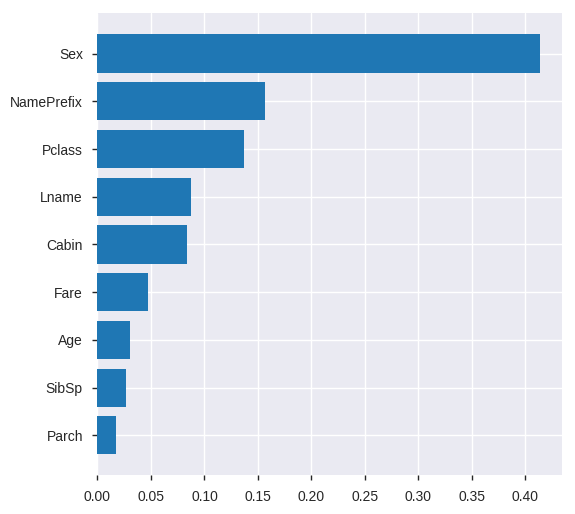

In [58]:
features = X_train.columns
importances = gs.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], align='center') # 除外, color=''
plt.yticks(range(len(indices)), features[indices])
plt.show()

性別が最もモデルの影響を与えていることがわかります。  
また、この重要特徴量の可視化は、他のモデルにおいて  
特徴量選択の助けになるので、ランダムフォレストによるモデル作成以外の場面でも大変役に立ちます。  